# M4U3 — Construction Site Safety Detection (YOLOv8)

## Goal
Train and evaluate a YOLOv8 object detection model to detect construction site safety objects and PPE violations from images, and produce both quantitative metrics and visual evidence on unseen test data.

---

## Dataset
Kaggle (Roboflow export):  
https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow

The dataset is organized in YOLO format with separate **train / validation / test** splits and bounding box annotations.

---

## Classes (10)

0. Hardhat  
1. Mask  
2. NO-Hardhat  
3. NO-Mask  
4. NO-Safety Vest  
5. Person  
6. Safety Cone  
7. Safety Vest  
8. machinery  
9. vehicle  

---

## Frameworks and Tools

- Ultralytics YOLOv8
- PyTorch
- OpenCV
- Google Colab (GPU)

---

## Workflow Overview (Steps)

This notebook follows a structured end-to-end object detection pipeline:

**Step 1 — Environment setup**  
Install and configure YOLOv8 and required libraries.

**Step 2 — Dataset loading and structure check**  
Verify dataset folders and splits (train / valid / test).

**Step 3 — Annotation format validation**  
Inspect label files and class index mapping.

**Step 4 — Dataset configuration (data.yaml)**  
Create and verify YOLO dataset configuration file.

**Step 5 — Model training**  
Fine-tune YOLOv8 pretrained weights on the custom dataset.

**Step 6 — Training metrics and curves**  
Analyze loss curves, precision/recall, mAP, and confusion matrices.

**Step 7 — Inference on TEST set**  
Run predictions on unseen test images and save annotated outputs.

**Step 8 — Formal TEST evaluation**  
Compute quantitative metrics on the held-out test split.

**Step 9 — Visual and tabular prediction inspection**  
- Step 9A — Visual bounding box verification  
- Step 9B — Per-image prediction tables

**Step 10 — Export artifacts**  
Package trained weights, metrics, curves, and prediction evidence for submission.

---

## Step 1 — Environment Setup and Imports

This section installs required libraries and imports all dependencies used in the notebook, including YOLOv8, Torch, OpenCV, and supporting utilities.

GPU availability is also verified to ensure accelerated training.

In [6]:
!pip -q install ultralytics kaggle pyyaml opencv-python matplotlib

In [7]:
import os
import json
import yaml
import shutil
import zipfile
import random
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO

print("✅ Imports ready")
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

✅ Imports ready
GPU available: True
GPU: Tesla T4


## Step 2 — Dataset Loading and Extraction

The dataset archive is loaded from Google Drive and extracted into the Colab runtime environment.

The dataset follows YOLO format with the required folder structure:

train/
images/ + labels/

valid/
images/ + labels/

test/
images/ + labels/

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
ZIP_PATH = "/content/drive/MyDrive/_Zigurat/Dataset.zip"
OUT_PATH = "/content/dataset"

os.makedirs(OUT_PATH, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(OUT_PATH)

print("✅ Dataset extracted to:", OUT_PATH)
print("Top files/folders:", os.listdir(OUT_PATH))

✅ Dataset extracted to: /content/dataset
Top files/folders: ['css-data', 'results_yolov8n_100e', 'source_files']


## Step 3 — Dataset Structure Verification

The extracted dataset directories are inspected to confirm:

- Presence of train / validation / test splits
- Each split contains images and labels folders
- Label files match image counts

This step prevents training failures due to missing annotations.

In [11]:
DATA_ROOT = "/content/dataset/css-data"

print("Root:", os.listdir(DATA_ROOT))
print("\nTrain:", os.listdir(DATA_ROOT + "/train"))
print("\nValid:", os.listdir(DATA_ROOT + "/valid"))
print("\nTest:", os.listdir(DATA_ROOT + "/test"))

Root: ['README.dataset.txt', 'train', 'valid', 'test', 'README.roboflow.txt']

Train: ['images', 'labels']

Valid: ['images', 'labels']

Test: ['images', 'labels']


## Step 4 — YOLO Dataset Configuration (data.yaml)

A dataset configuration file is generated describing:

- Root dataset path
- Train / validation / test image folders
- Class names and class index order

YOLO automatically links images to label files using matching filenames.

In [12]:
DATA_ROOT = "/content/dataset/css-data"

data_yaml = {
    "path": DATA_ROOT,
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "names": [
        "Hardhat",
        "Mask",
        "NO-Hardhat",
        "NO-Mask",
        "NO-Safety Vest",
        "Person",
        "Safety Cone",
        "Safety Vest",
        "machinery",
        "vehicle"
    ]
}

with open("/content/data.yaml", "w") as f:
    yaml.dump(data_yaml, f)

print("✅ data.yaml created")

✅ data.yaml created


In [13]:
# verify yaml + counts
with open("/content/data.yaml", "r") as f:
    cfg = yaml.safe_load(f)

print("YAML keys:", cfg.keys())
print("Classes:", len(cfg["names"]), cfg["names"])

train_imgs = len(os.listdir(os.path.join(cfg["path"], "train/images")))
train_lbls = len(os.listdir(os.path.join(cfg["path"], "train/labels")))
val_imgs   = len(os.listdir(os.path.join(cfg["path"], "valid/images")))
val_lbls   = len(os.listdir(os.path.join(cfg["path"], "valid/labels")))
test_imgs  = len(os.listdir(os.path.join(cfg["path"], "test/images")))
test_lbls  = len(os.listdir(os.path.join(cfg["path"], "test/labels")))

print("\nCounts:")
print("Train images/labels:", train_imgs, train_lbls)
print("Valid images/labels:", val_imgs, val_lbls)
print("Test  images/labels:", test_imgs, test_lbls)

YAML keys: dict_keys(['names', 'path', 'test', 'train', 'val'])
Classes: 10 ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

Counts:
Train images/labels: 2605 2605
Valid images/labels: 114 114
Test  images/labels: 82 82


## Step 5 — Model Training

A pretrained YOLOv8 model is fine-tuned on the custom construction safety dataset.

Training configuration:
- Base weights: YOLOv8 pretrained model
- Image size: 640
- Epochs: 30
- Batch size: 16
- Automatic validation each epoch

During training, YOLO automatically logs:
- Training and validation losses
- Precision and recall
- mAP metrics
- Training curves and confusion matrices

Outputs are saved under the training run directory.

In [14]:
model = YOLO("yolov8n.pt")

results = model.train(
    data="/content/data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    project="/content/yolo_runs",
    name="m4u3_yolov8n"
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=m4u3_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

## Step 6 — Training Metrics and Curves

YOLO automatically generates training diagnostics and visual reports.

Key loss terms:

- **box_loss** — bounding box localization error
- **cls_loss** — classification error
- **dfl_loss** — distribution focal loss for box quality

Lower values indicate improved learning.

Generated visual reports include:
- Loss curves (train vs validation)
- Precision and recall curves
- mAP@50 and mAP@50–95 curves
- Confusion matrix
- Normalized confusion matrix

These plots help assess convergence, class confusion, and overfitting risk.


Run folder: /content/yolo_runs/m4u3_yolov8n
Contents: ['labels.jpg', 'train_batch3262.jpg', 'train_batch3261.jpg', 'train_batch0.jpg', 'val_batch0_labels.jpg', 'train_batch1.jpg', 'args.yaml', 'val_batch1_pred.jpg', 'val_batch1_labels.jpg', 'results.png', 'confusion_matrix_normalized.png', 'results.csv', 'val_batch2_labels.jpg', 'BoxPR_curve.png', 'train_batch2.jpg', 'val_batch0_pred.jpg', 'BoxF1_curve.png', 'confusion_matrix.png', 'BoxP_curve.png', 'BoxR_curve.png', 'weights', 'val_batch2_pred.jpg', 'train_batch3260.jpg']

Existing curve images:
 - /content/yolo_runs/m4u3_yolov8n/results.png
 - /content/yolo_runs/m4u3_yolov8n/confusion_matrix.png
 - /content/yolo_runs/m4u3_yolov8n/confusion_matrix_normalized.png


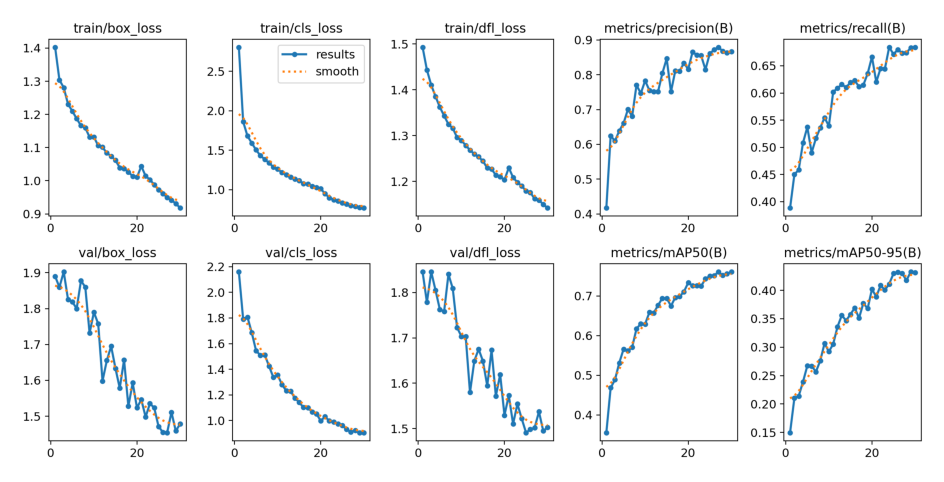

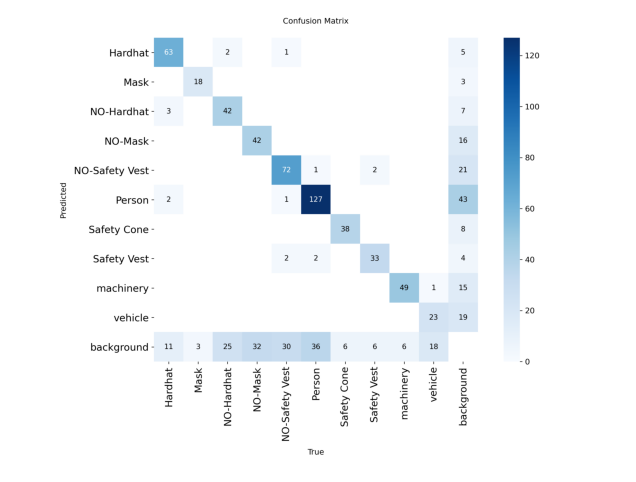

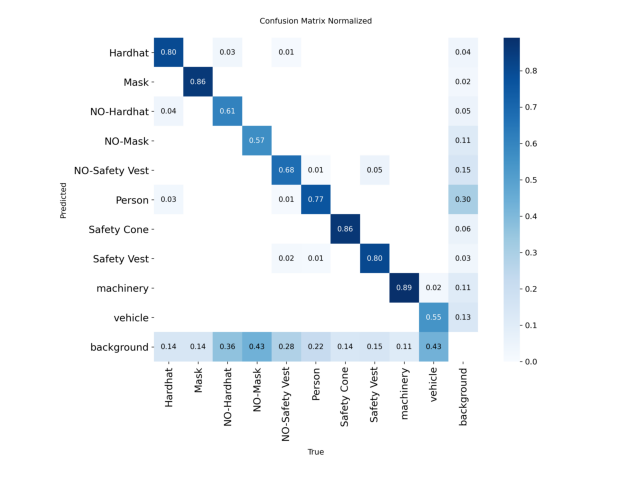

In [23]:
RUN_DIR = "/content/yolo_runs/m4u3_yolov8n"
print("Run folder:", RUN_DIR)
print("Contents:", os.listdir(RUN_DIR))

curve_imgs = [
    os.path.join(RUN_DIR, "results.png"),
    os.path.join(RUN_DIR, "confusion_matrix.png"),
    os.path.join(RUN_DIR, "confusion_matrix_normalized.png"),
    os.path.join(RUN_DIR, "PR_curve.png"),
    os.path.join(RUN_DIR, "P_curve.png"),
    os.path.join(RUN_DIR, "R_curve.png"),
    os.path.join(RUN_DIR, "F1_curve.png"),
]

existing = [p for p in curve_imgs if os.path.exists(p)]
print("\nExisting curve images:")
for p in existing:
    print(" -", p)

for p in existing:
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


## Step 7 — Inference on Test Set

After training, the best checkpoint (`best.pt`) is used for inference on the unseen test set.

This step:
- Loads trained weights
- Runs detection on test images
- Draws predicted bounding boxes
- Adds class names and confidence scores
- Saves annotated images

These outputs provide visual evidence of model performance.

In [15]:
RUN_DIR   = "/content/yolo_runs/m4u3_yolov8n"
WEIGHTS   = f"{RUN_DIR}/weights/best.pt"

TEST_DIR  = "/content/dataset/css-data/test/images"
OUT_DIR   = "/content/results/predictions_test"

os.makedirs(OUT_DIR, exist_ok=True)

# sanity checks
print("✅ weights exists:", os.path.exists(WEIGHTS), WEIGHTS)
print("✅ test images folder exists:", os.path.exists(TEST_DIR), TEST_DIR)
print("Test images count:", len([f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))]))

# load model + predict
model = YOLO(WEIGHTS)

results = model.predict(
    source=TEST_DIR,
    imgsz=640,
    conf=0.25,
    iou=0.7,
    save=True,          # save annotated images
    save_txt=True,      # save YOLO-format predictions
    project=OUT_DIR,    # root output folder
    name="pred",        # subfolder name
    exist_ok=True
)

print("✅ Done. Predictions saved to:")
print(f"{OUT_DIR}/pred")
print("Files inside pred:", os.listdir(f"{OUT_DIR}/pred")[:10])

✅ weights exists: True /content/yolo_runs/m4u3_yolov8n/weights/best.pt
✅ test images folder exists: True /content/dataset/css-data/test/images
Test images count: 82

image 1/82 /content/dataset/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Hardhat, 1 Person, 8.3ms
image 2/82 /content/dataset/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 1 NO-Mask, 2 NO-Safety Vests, 3 Persons, 1 machinery, 7.3ms
image 3/82 /content/dataset/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 1 NO-Mask, 2 NO-Safety Vests, 4 Persons, 7.9ms
image 4/82 /content/dataset/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 1 Safety Cone, 13.4ms
image 5/82 /content/dataset/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 4 NO-Safety Vests, 6 Persons, 2 Safety Vest

## Step 8 — Final Quantitative Evaluation on TEST Set

After generating prediction examples, a formal quantitative evaluation is performed on the unseen TEST split.

This step uses the best trained checkpoint (best.pt) and computes official detection metrics on data that was never used during training or validation.

Purpose of this step:

- Produce final performance metrics
- Measure generalization on unseen data
- Report Precision, Recall, mAP@50, and mAP@50–95
- Generate evaluation artifacts such as confusion matrices and metric curves

This serves as the final numeric benchmark of model performance.


In [25]:
RUN_DIR   = "/content/yolo_runs/m4u3_yolov8n"
WEIGHTS   = f"{RUN_DIR}/weights/best.pt"
DATA_YAML = "/content/data.yaml"

model = YOLO(WEIGHTS)

# Evaluate on the TEST split (uses the 'test:' entry inside data.yaml)
metrics = model.val(data=DATA_YAML, split="test", imgsz=640, conf=0.25)

print("✅ TEST evaluation finished.")
print("📌 Results folder:", metrics.save_dir)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1545.6±572.4 MB/s, size: 51.4 KB)
val: Scanning /content/dataset/css-data/test/labels... 82 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 82/82 2.4Kit/s 0.0s
val: New cache created: /content/dataset/css-data/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.4it/s 4.3s
                   all         82        760      0.847      0.637      0.759      0.464
               Hardhat         30        110      0.966      0.772      0.901      0.614
                  Mask         16         28          1       0.75      0.875      0.572
            NO-Hardhat         25         41      0.801      0.537      0.664      0.357
               NO-Mask         30         79      0.803      0.516      0.6

## Step 9A — Visual Verification of Predictions (Class ID + Name + Confidence)

In this step, prediction results are visually re-rendered using the YOLO output label files to verify correct class mapping and bounding box decoding.

Instead of relying only on the default YOLO annotated images, bounding boxes are drawn manually so that each detection displays:

- Class ID
- Class name (from data.yaml mapping)
- Confidence score

This verification step confirms that:

- Predicted class indices correctly match the dataset label definitions
- YAML class name mapping is applied correctly
- Bounding box coordinates are properly converted from YOLO format to pixel format
- Confidence scores are correctly parsed
- Prediction label files (.txt) are consistent with visual outputs

Images are displayed one per row at large size to improve readability and inspection quality.

This provides transparent visual evidence linking numeric model outputs to semantic class labels.


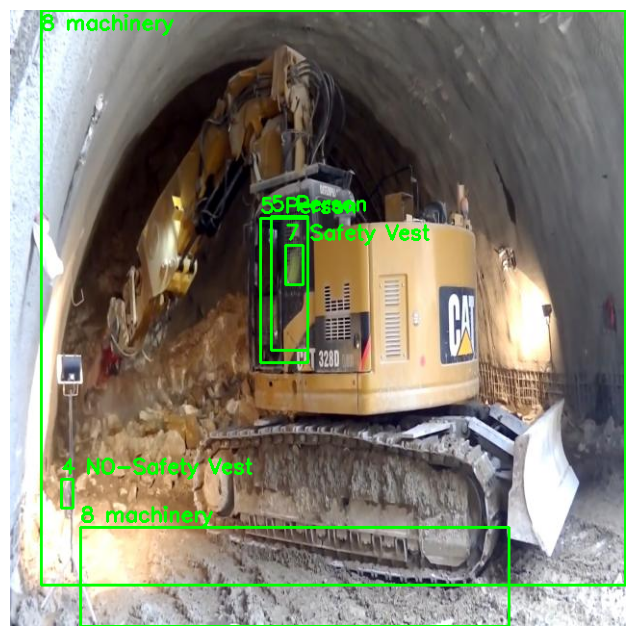

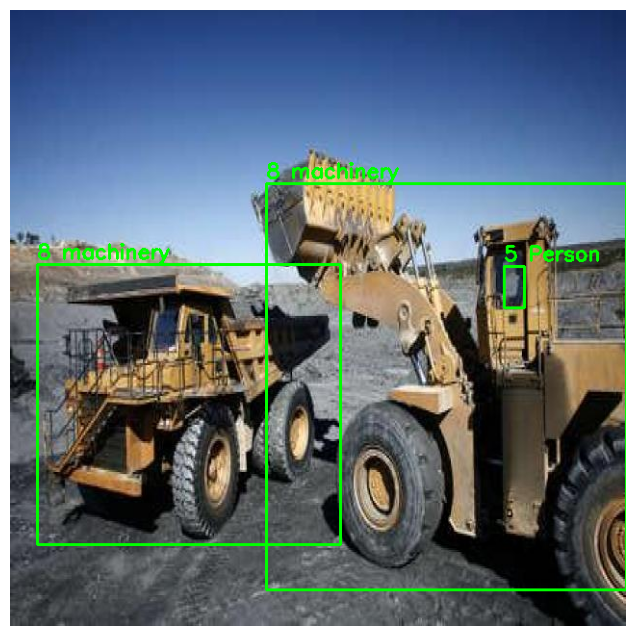

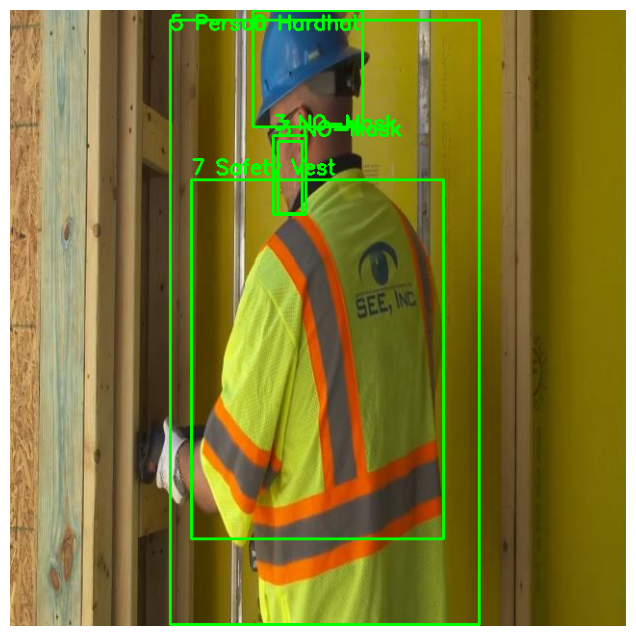

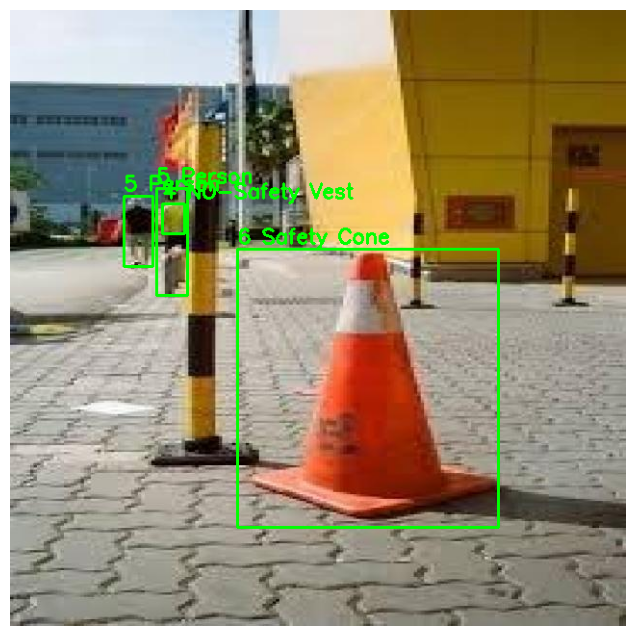

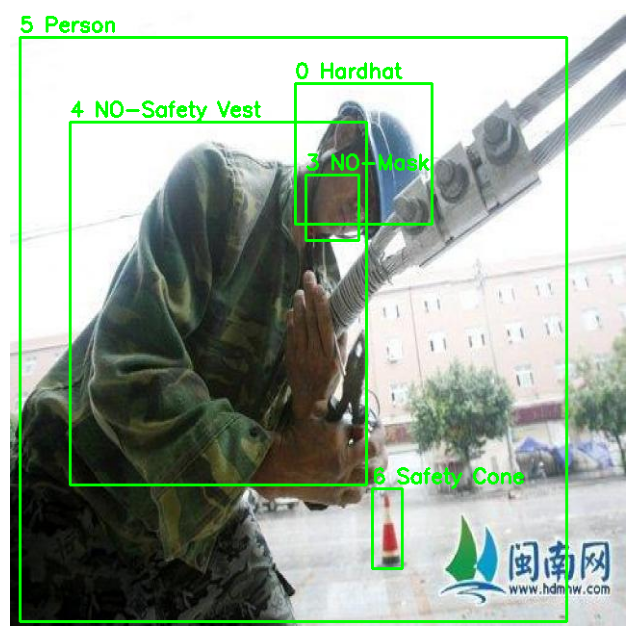

In [21]:
TEST_IMG_DIR = "/content/dataset/css-data/test/images"
PRED_LABEL_DIR = "/content/results/predictions_test/pred/labels"

sample_imgs = random.sample(
    [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith((".jpg",".jpeg",".png"))],
    5
)

for img_name in sample_imgs:
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    label_path = os.path.join(PRED_LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                cls = int(float(parts[0]))
                xc, yc, bw, bh = map(float, parts[1:5])
                conf = float(parts[5]) if len(parts) >= 6 else None

                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)

                name = cfg["names"][cls]
                label = f"{cls} {name}" + (f" {conf:.2f}" if conf else "")

                cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
                cv2.putText(img, label, (x1, max(20,y1-6)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

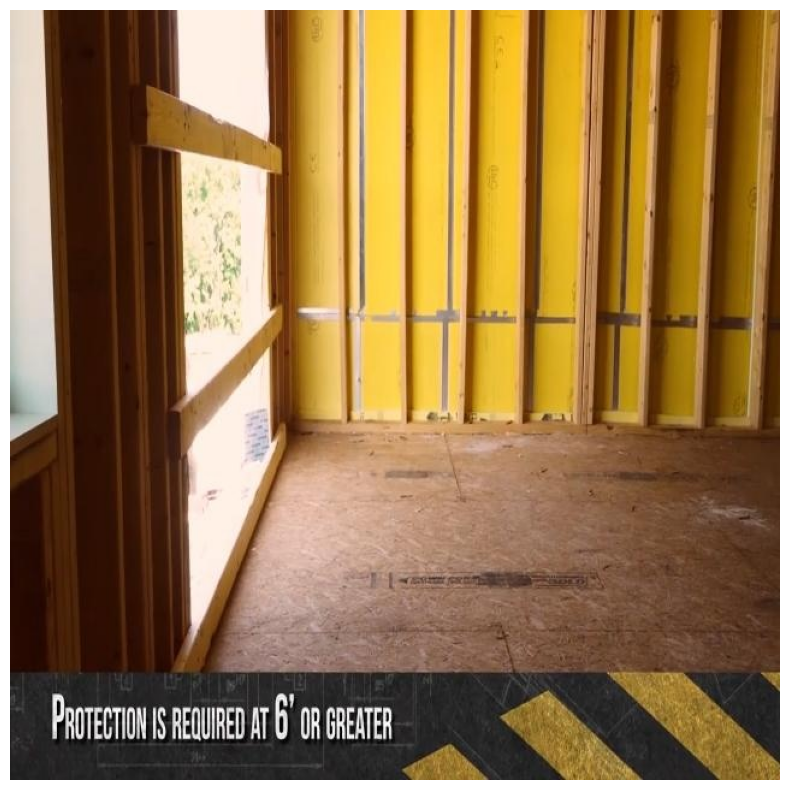

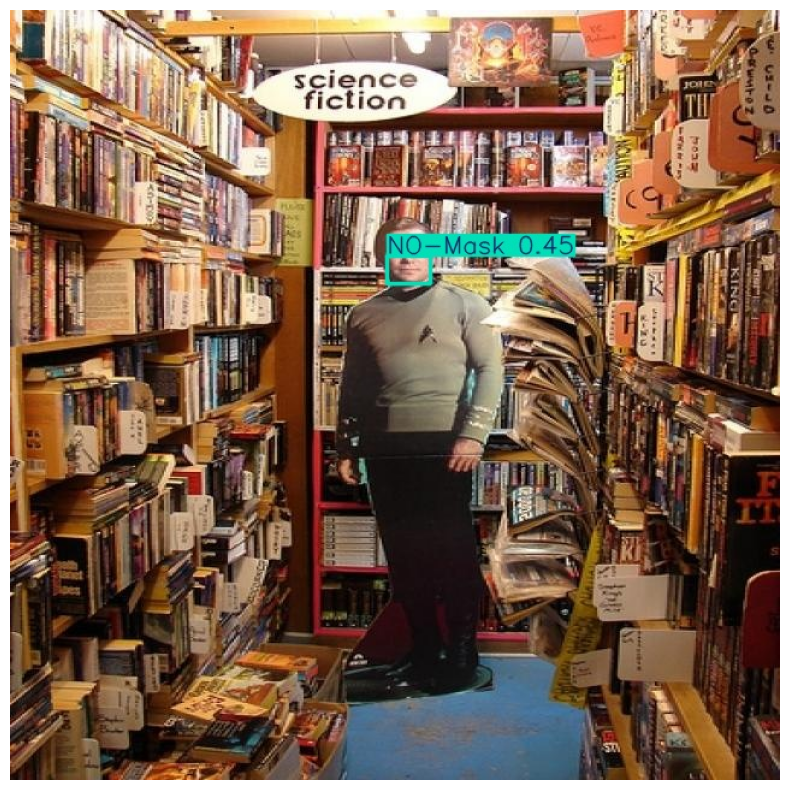

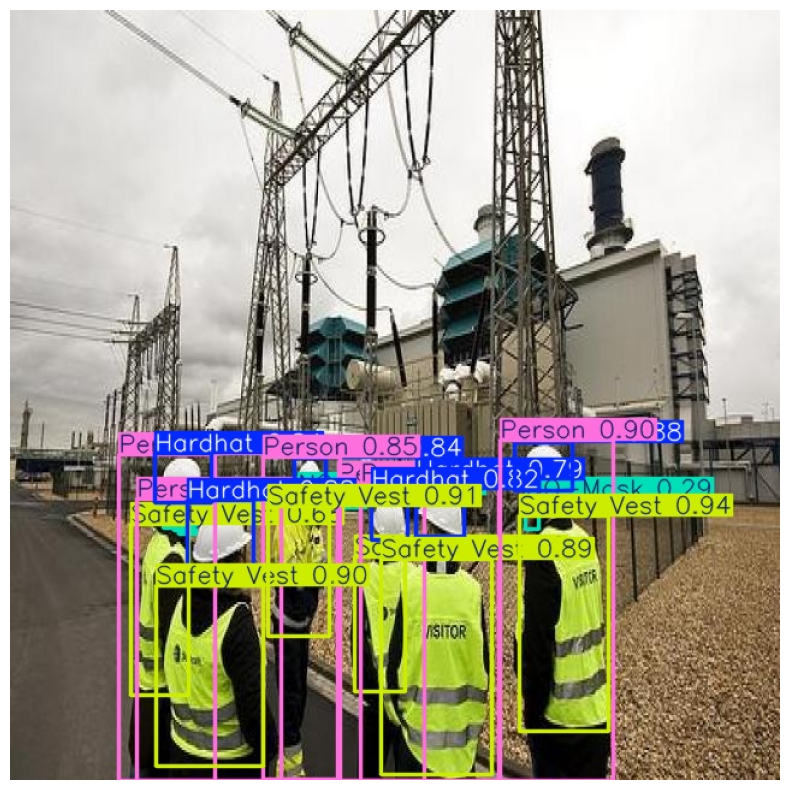

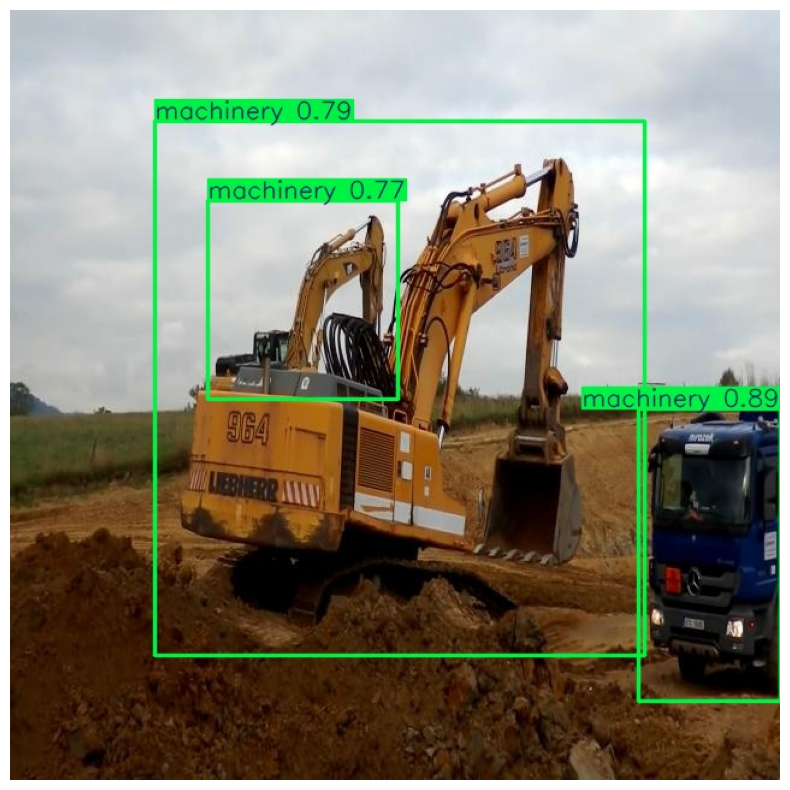

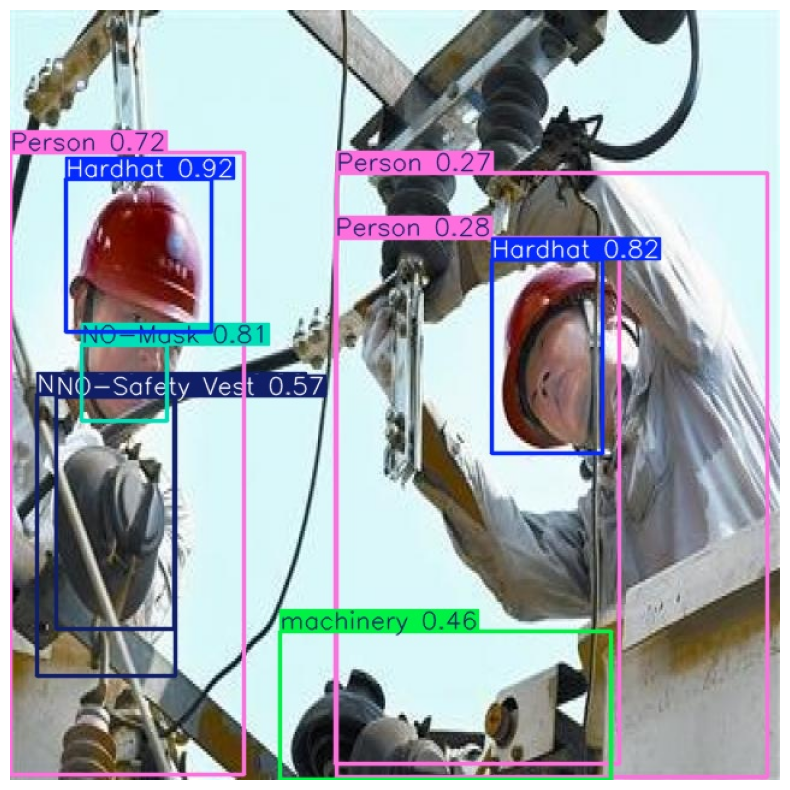

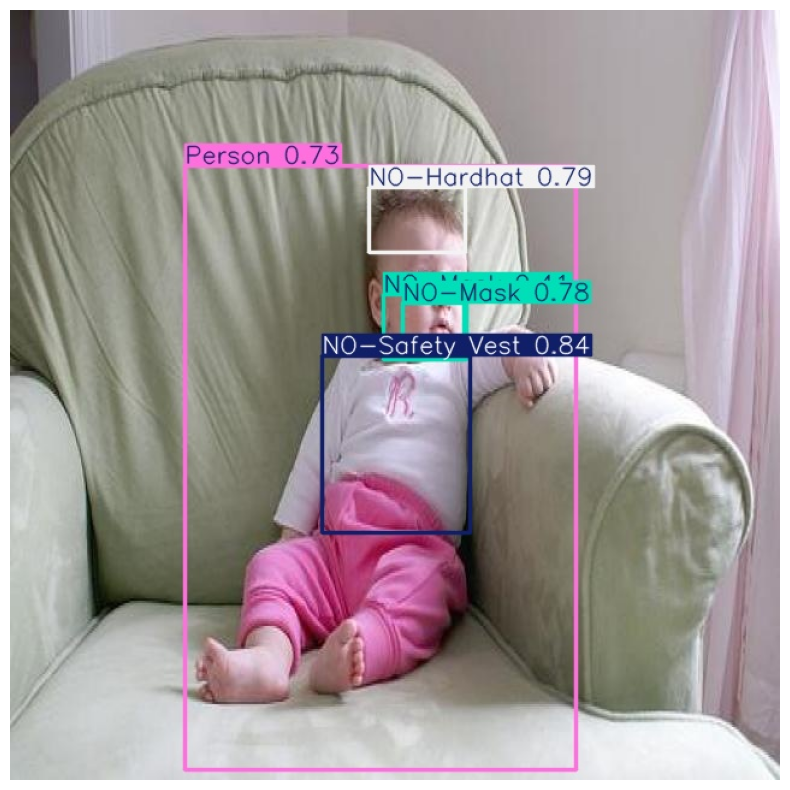

In [24]:
PRED_DIR = "/content/results/predictions_test/pred"
imgs = sorted([f for f in os.listdir(PRED_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png"))])

for name in random.sample(imgs, k=min(6, len(imgs))):
    img = cv2.imread(os.path.join(PRED_DIR, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


## Step 9B — Prediction Table per Image (Numeric Evidence)

In this step, a structured prediction table is generated for sample TEST images.

For each detected object, the following fields are reported:

- class_id
- class_name
- confidence score
- bounding box coordinates (x1, y1, x2, y2) in pixel space

This structured output enables precise inspection of model predictions and supports numeric validation beyond visual review.

It is useful for:

- verifying class index → label mapping
- analyzing confidence levels
- auditing bounding box coordinates
- enabling reproducible evaluation.

In [22]:
TEST_IMG_DIR   = "/content/dataset/css-data/test/images"
PRED_LABEL_DIR = "/content/results/predictions_test/pred/labels"

def yolo_xywh_to_xyxy_px(xc, yc, bw, bh, w, h):
    x1 = int((xc - bw/2) * w)
    y1 = int((yc - bh/2) * h)
    x2 = int((xc + bw/2) * w)
    y2 = int((yc + bh/2) * h)
    # clip to image bounds
    x1 = max(0, min(w-1, x1))
    y1 = max(0, min(h-1, y1))
    x2 = max(0, min(w-1, x2))
    y2 = max(0, min(h-1, y2))
    return x1, y1, x2, y2

# pick a few images to tabulate
img_files = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
sample = random.sample(img_files, min(5, len(img_files)))

for img_name in sample:
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    label_path = os.path.join(PRED_LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    rows = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                cls = int(float(parts[0]))
                xc, yc, bw, bh = map(float, parts[1:5])

                # prediction labels may or may not include confidence
                conf = float(parts[5]) if len(parts) >= 6 else None

                x1, y1, x2, y2 = yolo_xywh_to_xyxy_px(xc, yc, bw, bh, w, h)
                cls_name = cfg["names"][cls] if "cfg" in globals() and "names" in cfg else str(cls)

                rows.append({
                    "image": img_name,
                    "class_id": cls,
                    "class_name": cls_name,
                    "conf": None if conf is None else round(conf, 3),
                    "x1": x1, "y1": y1, "x2": x2, "y2": y2
                })

    print("\n" + "="*80)
    print("IMAGE:", img_name)
    if not rows:
        print("No predictions found for this image.")
        continue

    # pretty print table (no pandas import needed)
    header = ["class_id", "class_name", "conf", "x1", "y1", "x2", "y2"]
    print(" | ".join(header))
    print("-" * 80)
    for r in rows:
        print(f"{r['class_id']:>8} | {r['class_name']:<14} | {str(r['conf']):<5} | "
              f"{r['x1']:<4} | {r['y1']:<4} | {r['x2']:<4} | {r['y2']:<4}")



IMAGE: bookstore_44_08_flickr_jpg.rf.244b6f308c529933af798c4063e58601.jpg
class_id | class_name | conf | x1 | y1 | x2 | y2
--------------------------------------------------------------------------------
       3 | NO-Mask        | None  | 313  | 204  | 349  | 227 

IMAGE: construction-639-_jpg.rf.7db2168ad99f643f7e3070733387e3bb.jpg
class_id | class_name | conf | x1 | y1 | x2 | y2
--------------------------------------------------------------------------------
       8 | machinery      | None  | 13   | 10   | 639  | 632 

IMAGE: youtube-263_jpg.rf.374e343e12ead395440dbd81417e1be9.jpg
class_id | class_name | conf | x1 | y1 | x2 | y2
--------------------------------------------------------------------------------
       9 | vehicle        | None  | 187  | 188  | 219  | 219 
       9 | vehicle        | None  | 260  | 197  | 293  | 227 
       9 | vehicle        | None  | 95   | 179  | 128  | 206 
       8 | machinery      | None  | 269  | 69   | 639  | 569 
       5 | Person         | N

## Step 10 — Export Model and Evaluation Artifacts

In this step, all important training and evaluation artifacts are collected and exported to a single output folder for submission and reproducibility.

The export package includes:

**Model checkpoints**
- `best.pt` — best-performing trained weights (selected by validation metrics)
- `last.pt` — final epoch weights

**Training diagnostics**
- Training results curves (`results.png`)
- Confusion matrix
- Normalized confusion matrix

**Prediction evidence**
- Test-set prediction images with bounding boxes
- Generated prediction label files

**Batch samples (if available)**
- Training and validation batch visualizations

A helper copy function is used to safely transfer files and folders only if they exist.  
The final structured output directory can then be downloaded or pushed to a repository for review and grading.

In [26]:
RUN_DIR   = "/content/yolo_runs/m4u3_yolov8n"
WEIGHTS_DIR = f"{RUN_DIR}/weights"
PRED_DIR  = "/content/results/predictions_test"
EVAL_DIR  = "/content/runs/detect/val"
DRIVE_OUT = "/content/drive/MyDrive/_Zigurat/M4U3_YOLOv8_Output"

if os.path.exists(DRIVE_OUT):
    shutil.rmtree(DRIVE_OUT)
os.makedirs(DRIVE_OUT, exist_ok=True)

def copy_if_exists(src, dst_folder):
    if os.path.exists(src):
        if os.path.isdir(src):
            shutil.copytree(src, os.path.join(dst_folder, os.path.basename(src)))
        else:
            shutil.copy2(src, dst_folder)
        print("✅ Copied:", src)
    else:
        print("⚠️ Missing:", src)

# 1) weights
copy_if_exists(f"{WEIGHTS_DIR}/best.pt", DRIVE_OUT)
copy_if_exists(f"{WEIGHTS_DIR}/last.pt", DRIVE_OUT)

# 2) training evidence (curves etc.)
copy_if_exists(f"{RUN_DIR}/results.png", DRIVE_OUT)
copy_if_exists(f"{RUN_DIR}/confusion_matrix.png", DRIVE_OUT)
copy_if_exists(f"{RUN_DIR}/confusion_matrix_normalized.png", DRIVE_OUT)

# 3) optional extra evidence images if exist
copy_if_exists(f"{RUN_DIR}/labels.jpg", DRIVE_OUT)
copy_if_exists(f"{RUN_DIR}/val_batch0_pred.jpg", DRIVE_OUT)
copy_if_exists(f"{RUN_DIR}/train_batch0.jpg", DRIVE_OUT)

# 4) test prediction images folder
copy_if_exists(PRED_DIR, DRIVE_OUT)

# 5) test evaluation folder (metrics + confusion matrix)
copy_if_exists(EVAL_DIR, DRIVE_OUT)

print("\n📦 DONE. All artifacts saved to:", DRIVE_OUT)
print("Open Drive > _Zigurat > M4U3_YOLOv8_Output")

✅ Copied: /content/yolo_runs/m4u3_yolov8n/weights/best.pt
✅ Copied: /content/yolo_runs/m4u3_yolov8n/weights/last.pt
✅ Copied: /content/yolo_runs/m4u3_yolov8n/results.png
✅ Copied: /content/yolo_runs/m4u3_yolov8n/confusion_matrix.png
✅ Copied: /content/yolo_runs/m4u3_yolov8n/confusion_matrix_normalized.png
✅ Copied: /content/yolo_runs/m4u3_yolov8n/labels.jpg
✅ Copied: /content/yolo_runs/m4u3_yolov8n/val_batch0_pred.jpg
✅ Copied: /content/yolo_runs/m4u3_yolov8n/train_batch0.jpg
✅ Copied: /content/results/predictions_test
✅ Copied: /content/runs/detect/val

📦 DONE. All artifacts saved to: /content/drive/MyDrive/_Zigurat/M4U3_YOLOv8_Output
Open Drive > _Zigurat > M4U3_YOLOv8_Output


## Final Step — Download Final Output Package

This step compresses the full experiment output folder into a single ZIP file and downloads it locally.

The package includes:
- trained weights (best.pt, last.pt)
- training curves and metrics plots
- confusion matrices
- validation/test prediction samples
- evaluation artifacts

This ZIP is then uploaded to the GitHub repository as the results evidence pack.

In [27]:
# ===== Final Step — Zip and Download Output Package =====

OUT_ROOT = "/content/drive/MyDrive/_Zigurat/M4U3_YOLOv8_Output"
ZIP_PATH = "/content/M4U3_YOLOv8_Output.zip"

print("Zipping:", OUT_ROOT)

shutil.make_archive(
    base_name=ZIP_PATH.replace(".zip",""),
    format="zip",
    root_dir=OUT_ROOT
)

print("✅ Zip created:", ZIP_PATH)

from google.colab import files
files.download(ZIP_PATH)

Zipping: /content/drive/MyDrive/_Zigurat/M4U3_YOLOv8_Output
✅ Zip created: /content/M4U3_YOLOv8_Output.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>